In [1]:
!pip install lightkurve
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install tensorflow

In [3]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import scipy
import pandas as pd 
from scipy import interpolate

In [4]:
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [5]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5
        

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# BiSON Data

In [7]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [8]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

In [9]:
def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

In [10]:
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


# Sunspot Count

In [11]:
#sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
sunspot_Day = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

#sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [12]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

In [13]:
def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

In [14]:
getSN_Day(cycle_23)

array([[2.4502965e+06, 2.6000000e+01],
       [2.4502975e+06, 3.1000000e+01],
       [2.4502985e+06, 3.1000000e+01],
       ...,
       [2.4547985e+06, 0.0000000e+00],
       [2.4547995e+06, 0.0000000e+00],
       [2.4548005e+06, 0.0000000e+00]])

In [15]:
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

# Preprocessing

In [16]:
datax_SV = getSV_index(cycle_23)
datay_SV = getSV(cycle_23)


# plt.xlabel('Time (BJD)')
# plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

# #Axis 1
# plt.autoscale(enable=True, axis='both', tight=None)
# plt.scatter(datax_SV,datay_SV, s = 10, c='blue', alpha=0.5)
# plt.show()
print(datax_SV.size)

9730800


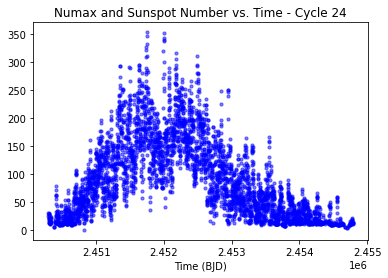

9010


In [17]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),91.25)
data_SN = np.ma.masked_equal(getSN_Day(cycle_23),0)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]

plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(datax_SN,datay_SN, s = 10, c='blue', alpha=0.5)
plt.show()
print(data_SN.size)

In [93]:
def prepXY(datax,datay,duration):
  oldx = np.reshape(datax, (-1, 2160))
  size = (duration-1)/2
  newx = oldx[:int(len(oldx)-size)]
  for i in range(int(size),int(len(oldx)-size)):
    newx[i] = np.append(newx[i],(oldx[i][i-size+j] for j in range(duration)))
  # newx = np.zeros([int(len(datax)/2160-duration),duration])
  # for i in range(int(len(datax)/2160-duration)):
  #   for j in range(duration):
  #     newx[i][j] = datax[i+j]
  # newx = np.array(list(zip(*(datax[i:] for i in range(duration)))))
  newy = datay[int((duration-1)/2):-int((duration-1)/2)]
  return newx, newy

In [94]:
x, y = prepXY(getSV(cycle_23),getSN_Day(cycle_23).T[1],5)
print(x.shape,y.shape)
print(x)

ValueError: ignored

In [31]:
train_x = getSV(cycle_23)
train_y = getSN_Day(cycle_23).T[1]
print(train_x.shape, train_y.shape)
train_x = np.reshape(train_x, (-1, 2160))
print(train_x.shape)
print(max(train_y))

# normalize
train_y = np.divide(train_y,353.0)
print(max(train_y),train_y.shape)

(9730800,) (4505,)
(4505, 2160)
353.0
1.0 (4505,)


In [32]:
tf.test.gpu_device_name()
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()

model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))
model.add(layers.Dense(512, activation='relu', input_shape=(train_x.shape)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4505, 512)         1106432   
_________________________________________________________________
dense_1 (Dense)              (None, 4505, 16)          8208      
_________________________________________________________________
dense_2 (Dense)              (None, 4505, 1)           17        
Total params: 1,114,657
Trainable params: 1,114,657
Non-trainable params: 0
_________________________________________________________________


In [19]:
# model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [38]:
history = model.fit(train_x, train_y, epochs=100,
                   validation_data=(train_x, train_y))

Epoch 1/100
141/141 [==============================] - 1s 11ms/step - loss: 0.0053 - accuracy: 0.1376 - val_loss: 0.0045 - val_accuracy: 0.1376
Epoch 2/100
141/141 [==============================] - 1s 11ms/step - loss: 0.0050 - accuracy: 0.1376 - val_loss: 0.0046 - val_accuracy: 0.1376
Epoch 3/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0050 - accuracy: 0.1376 - val_loss: 0.0047 - val_accuracy: 0.1376
Epoch 4/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0042 - accuracy: 0.1376 - val_loss: 0.0037 - val_accuracy: 0.1376
Epoch 5/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0034 - accuracy: 0.1376 - val_loss: 0.0029 - val_accuracy: 0.1376
Epoch 6/100
141/141 [==============================] - 1s 11ms/step - loss: 0.0028 - accuracy: 0.1376 - val_loss: 0.0027 - val_accuracy: 0.1376
Epoch 7/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0026 - accuracy: 0.1376 - val_loss: 0.0025 - val_accuracy:

In [ ]:
print(history.history)

{'loss': [199.88844299316406, 178.529052734375, 153.8533935546875, 133.98526000976562, 115.67385864257812, 95.59644317626953, 78.89146423339844, 65.99067687988281, 53.349430084228516, 37.470706939697266], 'acc': [0.0795768, 0.07765839, 0.07665352, 0.075070076, 0.07440016, 0.073547535, 0.07248176, 0.07199454, 0.07120282, 0.0701675], 'val_loss': [178.529052734375, 153.8533935546875, 133.98526000976562, 115.67385864257812, 95.59644317626953, 78.89146423339844, 65.99067687988281, 53.349430084228516, 37.470706939697266, 27.232019424438477], 'val_acc': [0.07765839, 0.07665352, 0.075070076, 0.07440016, 0.073547535, 0.07248176, 0.07199454, 0.07120282, 0.0701675, 0.06946713]}


In [39]:
pred_y = model.predict(train_x)

In [40]:
pred_y = pred_y.reshape(-1)
pred_y = np.multiply(pred_y,353.0)
print(pred_y)

[12.693978   27.079826   28.955885   ... -2.6038384  -0.11858392
 -5.7879043 ]


(4505,) (4505,) (4505,)


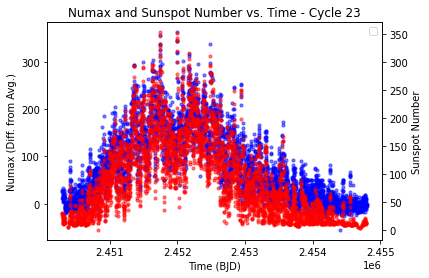

In [42]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),91.25)
data_SN = np.ma.masked_equal(getSN_Day(cycle_23),0)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]
print(datax_SN.shape, datay_SN.shape, pred_y.shape)

figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 23')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('Numax (Diff. from Avg.)')
axis_1.scatter(datax_SN,pred_y, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.scatter(datax_SN,datay_SN, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()

In [47]:
test_x = getSV(cycle_24)[:-2158]
test_x = np.reshape(test_x, (-1,2160))
print(test_x.shape)
test_y = model.predict(test_x)
test_y = test_y.reshape(-1)
test_y = np.multiply(test_y,353.0)
print(test_y)

(4138, 2160)
[ 67.02815  114.00011   24.982061 ...  59.252518  59.252518  59.252518]


(4138,) (4138,) (4138,)


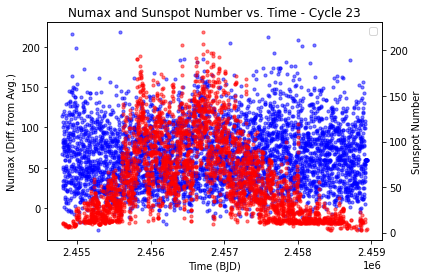

In [49]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),91.25)
data_SN = np.ma.masked_equal(getSN_Day(cycle_24),0)[:-1]
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]
print(datax_SN.shape, datay_SN.shape, test_y.shape)

figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 23')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('Numax (Diff. from Avg.)')
axis_1.scatter(datax_SN,test_y, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.scatter(datax_SN,datay_SN, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()